In [ ]:
import pandas as pd
from fastai.vision.all import *
import timm
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

In [13]:
main_path = "/mnt/c/Documents and Settings/sriha/Documents/DL/Datasets/Retina_DS"
labels_path = main_path + "/labels"
train15 = "resized_train_cropped/resized_train_cropped/"
test15 = "resized test 15/"
train19 = "resized train 19/"
format = ".jpeg"

In [14]:
df = pd.read_csv(labels_path + "/trainLabels_cropped.csv")
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'],inplace=True)
df['image'] = df['image'].apply(lambda x : train15 + x + format)
df

,image,level
0,resized_train_cropped/resized_train_cropped/10_left.jpeg,0
1,resized_train_cropped/resized_train_cropped/10_right.jpeg,0
2,resized_train_cropped/resized_train_cropped/13_left.jpeg,0
3,resized_train_cropped/resized_train_cropped/13_right.jpeg,0
4,resized_train_cropped/resized_train_cropped/15_left.jpeg,1
...,...,...
35103,resized_train_cropped/resized_train_cropped/44347_right.jpeg,0
35104,resized_train_cropped/resized_train_cropped/44348_left.jpeg,0
35105,resized_train_cropped/resized_train_cropped/44348_right.jpeg,0
35106,resized_train_cropped/resized_train_cropped/44349_left.jpeg,0


In [15]:
df2 = pd.read_csv(labels_path + "/testLabels15.csv")
df2.drop(columns=["Usage"],inplace=True)
df2['image'] = df2["image"].apply(lambda x : test15 + x + ".jpg")
df2

,image,level
0,resized test 15/1_left.jpg,0
1,resized test 15/1_right.jpg,0
2,resized test 15/2_left.jpg,0
3,resized test 15/2_right.jpg,0
4,resized test 15/3_left.jpg,2
...,...,...
53571,resized test 15/44346_right.jpg,0
53572,resized test 15/44350_left.jpg,0
53573,resized test 15/44350_right.jpg,0
53574,resized test 15/44351_left.jpg,0


In [16]:
df1 = pd.read_csv(labels_path + "/trainLabels19.csv")
df1.rename(columns={"id_code":"image","diagnosis":"level"},inplace=True)
df1['image'] = df1['image'].apply(lambda x : train19 + x + ".jpg")
df1

,image,level
0,resized train 19/000c1434d8d7.jpg,2
1,resized train 19/001639a390f0.jpg,4
2,resized train 19/0024cdab0c1e.jpg,1
3,resized train 19/002c21358ce6.jpg,0
4,resized train 19/005b95c28852.jpg,0
...,...,...
3657,resized train 19/ffa47f6a7bf4.jpg,2
3658,resized train 19/ffc04fed30e6.jpg,0
3659,resized train 19/ffcf7b45f213.jpg,2
3660,resized train 19/ffd97f8cd5aa.jpg,0


In [17]:
train_df = pd.concat([df,df1,df2],axis=0)
train_df.drop_duplicates(inplace=True)
train_df

,image,level
0,resized_train_cropped/resized_train_cropped/10_left.jpeg,0
1,resized_train_cropped/resized_train_cropped/10_right.jpeg,0
2,resized_train_cropped/resized_train_cropped/13_left.jpeg,0
3,resized_train_cropped/resized_train_cropped/13_right.jpeg,0
4,resized_train_cropped/resized_train_cropped/15_left.jpeg,1
...,...,...
53571,resized test 15/44346_right.jpg,0
53572,resized test 15/44350_left.jpg,0
53573,resized test 15/44350_right.jpg,0
53574,resized test 15/44351_left.jpg,0


In [18]:
class GaussianBlurTransform(RandTransform):
    def _init_(self, p=0.5, ksize=(5,5), sigmaX=0):
        super()._init_(p=p)
        self.ksize = ksize
        self.sigmaX = sigmaX

    def encodes(self, img: PILImage):
        arr = np.array(img)
        arr = cv2.GaussianBlur(arr, self.ksize, self.sigmaX)
        return PILImage.create(arr)


In [19]:
# target_max_rotate = 180.
# target_min_zoom = 1.0 - 0.2
# target_max_zoom = 1.0 + 0.2
# target_max_lighting = 0.2
# target_max_warp = 0.2
# target_do_flip = True

# batch_tfms = aug_transforms(
#     mult=1.0,
#     do_flip=target_do_flip,
#     flip_vert=False,
#     max_rotate=target_max_rotate,
#     min_zoom=target_min_zoom,
#     max_zoom=target_max_zoom,
#     max_lighting=target_max_lighting,
#     max_warp=target_max_warp,
#     p_affine=0.75,
#     p_lighting=0.75
# )

In [32]:
class CLAHETransformBW(Transform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p

    def encodes(self, img: PILImage):
        if np.random.rand() > self.p:
            return img

        img_np = np.array(img.convert("L")) 
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        cl = clahe.apply(img_np)

        cl_rgb = cv2.cvtColor(cl, cv2.COLOR_GRAY2RGB)

        return PILImage.create(cl_rgb)

In [ ]:
batch_tfms = aug_transforms(
    do_flip=True,
    flip_vert=False,
    max_rotate=180.,
    max_zoom=1.2,
    max_warp=0.2,
    max_lighting=0.2,
    p_lighting=0.75,
    xtra_tfms=[
        RandomResizedCrop(224, min_scale=0.8),
        CLAHETransformBW(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        Brightness(max_lighting=0.2, p=0.5),
        Contrast(max_lighting=0.2, p=0.5),
        Saturation(max_lighting=0.2, p=0.5),
        GaussianBlurTransform(p=0.3),
        RandomErasing(p=0.1)
    ]
)

In [51]:
dls = ImageDataLoaders.from_df(
    train_df,
    valid_pct=0.2,
    path=Path(main_path),
    fn_col='image',
    label_col='level',
    item_tfms=Resize(512),
    bs=8,
    batch_tfms=batch_tfms
)
len(dls.train_ds), len(dls.valid_ds)

(73877, 18469)

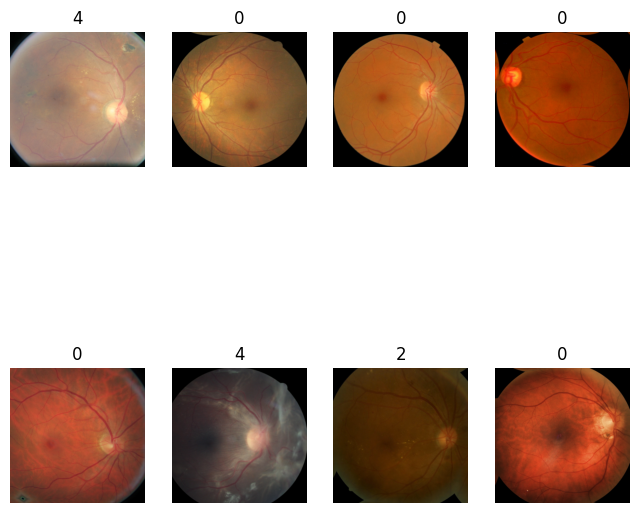

In [55]:
dls.show_batch(max_n=9, figsize=(8,8))

In [ ]:
def roc_auc_macro(preds, targs):
    preds = preds.softmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return roc_auc_score(targs, preds, multi_class='ovr', average='macro')

def f1_macro(preds, targs):
    preds = preds.argmax(dim=-1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='macro')

def balanacc_macro(preds,targs):
    preds = preds.argmax(dim=-1).cpu().numpy()
    targs = targs.cpu().numpy()
    return balanced_accuracy_score(targs, preds)

In [ ]:
learn = vision_learner(dls, 'tiny_vit_21m_512', metrics=[accuracy,balanacc_macro,f1_macro,roc_auc_macro],n_out=5,opt_func=Adam)

In [ ]:
learn.lr_find()

In [11]:
try:
    learn.fine_tune(20)
except KeyboardInterrupt:
    print("Stopped due to manual intervention")

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.766498,0.743174,0.765120,0.234880,15:37


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.634745,0.625304,0.793492,0.206508,28:00
1,0.596199,0.559986,0.819590,0.180410,27:59
2,0.579403,0.559015,0.821701,0.178299,27:58
3,0.579566,0.525531,0.825816,0.174184,28:02
4,0.508897,0.522690,0.832043,0.167957,27:57
5,0.571148,0.503580,0.839569,0.160431,28:02
6,0.482471,0.535741,0.832639,0.167362,28:00


Stopped due to manual intervention


In [12]:
learn.export("/mnt/c/Documents and Settings/sriha/Documents/DL/models/retina_convnext_tiny_93K.pth")